## <font color='red'>Import Library</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    precision_recall_fscore_support, roc_curve, average_precision_score, precision_recall_curve
)
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint, uniform
from sklearn.base import clone

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## <font color='red'>Load and Configure</font>

### <font color='blue'>Load file</font>

In [2]:
data = pd.read_csv("../data/cleaned_stroke.csv")

### <font color='blue'>Configure and Preprocess</font>

In [3]:
# Features and target
data["stroke"] = data["stroke"].replace({"Yes": 1, "No": 0}).astype(int)
X = data.drop("stroke", axis=1)
y = data["stroke"].astype(int)

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Train-test split (stratified because stroke is imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## <font color='red'>Random Forest Classifier</font>

In [4]:
# ----- Base model -----
rf = RandomForestClassifier(
    class_weight='balanced',  # keep this for imbalance
    random_state=42, n_jobs=-1
)

# ----- Search space (broad but sensible) -----
param_dist = {
    "n_estimators": randint(200, 1200),
    "max_depth": randint(3, 40),              # None is powerful but try bounded depths
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["sqrt", "log2", None, 0.3, 0.5, 0.7],
    "bootstrap": [True, False]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For imbalance
scoring = {'pr_auc': 'average_precision', 'roc': 'roc_auc', 'rec': 'recall'}
rand = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=60, scoring=scoring, refit='pr_auc',  # try "f1", "balanced_accuracy", or "roc_auc"
    cv=cv, verbose=1, n_jobs=-1, random_state=42
)

rand.fit(X_train, y_train)
best_rf = rand.best_estimator_
print("Best params (random search):", rand.best_params_)
print("CV best score (pr_auc):", rand.best_score_)

bi = rand.best_index_
print("Best PR-AUC:", rand.cv_results_['mean_test_pr_auc'][bi])
print("Best ROC-AUC:", rand.cv_results_['mean_test_roc'][bi])
print("Best Recall:", rand.cv_results_['mean_test_rec'][bi])

# ----- small GridSearch around the best -----
grid_params = {
    "n_estimators": [best_rf.n_estimators-100, best_rf.n_estimators, best_rf.n_estimators+100],
    "max_depth": [max(3, (best_rf.max_depth or 0)-5), best_rf.max_depth, (None if best_rf.max_depth is None else best_rf.max_depth+5)],
    "min_samples_split": [max(2, best_rf.min_samples_split-2), best_rf.min_samples_split, best_rf.min_samples_split+2],
    "min_samples_leaf": [max(1, best_rf.min_samples_leaf-1), best_rf.min_samples_leaf, best_rf.min_samples_leaf+1],
    "max_features": [best_rf.max_features]
}

# Clean out any Nones that don't make sense in the grid
grid_params = {k: [v for v in vs if v is not None or k=="max_depth"] for k,vs in grid_params.items()}

grid = GridSearchCV(best_rf, param_grid=grid_params, refit="pr_auc", cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
final_rf = grid.best_estimator_
print("Best params (grid refine):", grid.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params (random search): {'bootstrap': True, 'max_depth': 29, 'max_features': 0.7, 'min_samples_leaf': 13, 'min_samples_split': 10, 'n_estimators': 458}
CV best score (pr_auc): 0.19530807708303405
Best PR-AUC: 0.19530807708303405
Best ROC-AUC: 0.8359546358132477
Best Recall: 0.5074358974358975
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params (grid refine): {'max_depth': 24, 'max_features': 0.7, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 458}


ROC-AUC (RF) = 0.819
PR-AUC  (RF) = 0.216


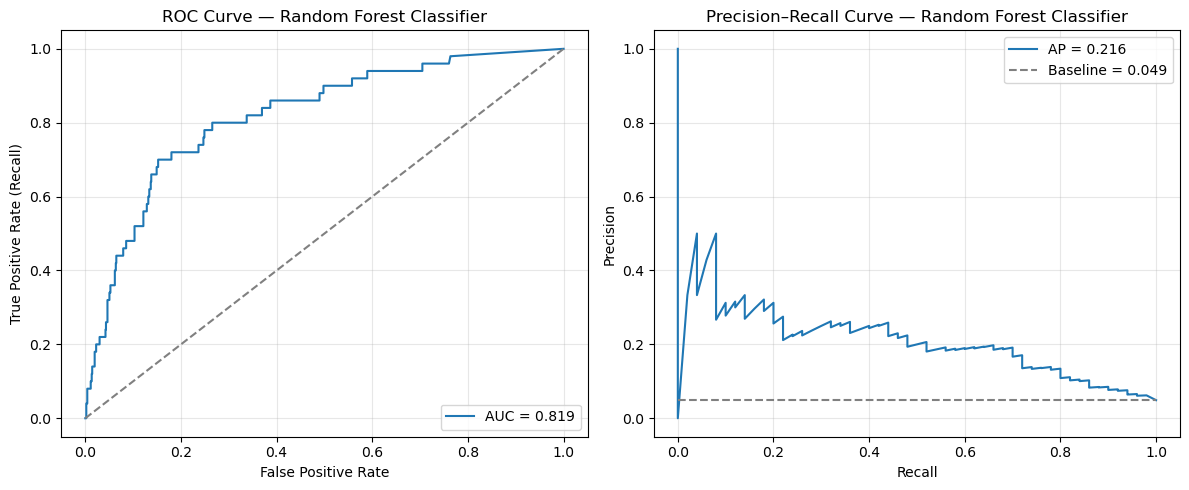

In [5]:
y_pred = final_rf.predict(X_test)
y_proba = final_rf.predict_proba(X_test)[:,1]

# Get predicted probabilities for the positive class (Stroke)
y_proba = final_rf.predict_proba(X_test)[:,1]

# # =============================
# # Plot Probability Distribution (For Checking)
# # =============================
# plt.figure(figsize=(6,4))
# plt.hist(y_proba, bins=50, color='steelblue', edgecolor='black')
# plt.xlabel("Predicted Probability (Stroke)")
# plt.ylabel("Count")
# plt.title("Probability Distribution of Model Outputs")
# plt.tight_layout()
# plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# PR
prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)   # This *is* PR-AUC

print(f"ROC-AUC (RF) = {roc_auc:.3f}")
print(f"PR-AUC  (RF) = {pr_auc:.3f}")

# Baseline positive prevalence
pos_rate = (y_test == 1).mean()

plt.figure(figsize=(12,5))

# --- ROC subplot ---
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.title("ROC Curve — Random Forest Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# --- PR subplot ---
plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"AP = {pr_auc:.3f}")
plt.hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"Baseline = {pos_rate:.3f}")
plt.title("Precision–Recall Curve — Random Forest Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# 1) Find best threshold (based on F1 for positive class)

thresholds = np.round(np.linspace(0.30, 0.70, 41), 2)
best_t = None
best_f1 = -1
best_cm = None
y_pred_best = None

for t in thresholds:
    y_pred_thresh = (y_proba > t).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred_thresh)
    
    if f1 > best_f1:
        best_f1 = f1
        best_t = t
        best_cm = cm
        y_pred_best = y_pred_thresh

print(f"Best Threshold = {best_t} (F1 = {best_f1:.3f})")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")
print("\nConfusion Matrix - Random Forest Classifier (Best Threshold):\n", best_cm)
print("\nClassification Report - Random Forest Classifier (Best Threshold):\n", 
      classification_report(
          y_test, 
          y_pred_best,
          target_names=["No Stroke", "Stroke"],
          digits=3
      ))

print("\n===== Testing Different Decision Thresholds =====")
for t in thresholds:
    y_pred_thresh = (y_proba > t).astype(int)

    acc = accuracy_score(y_test, y_pred_thresh)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_thresh, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_test, y_pred_thresh)

    print(f"\n=== Threshold = {t} ===")
    print(f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
    print("Confusion Matrix:\n", cm)

Best Threshold = 0.57 (F1 = 0.319)
Accuracy: 0.908

Confusion Matrix - Random Forest Classifier (Best Threshold):
 [[906  66]
 [ 28  22]]

Classification Report - Random Forest Classifier (Best Threshold):
               precision    recall  f1-score   support

   No Stroke      0.970     0.932     0.951       972
      Stroke      0.250     0.440     0.319        50

    accuracy                          0.908      1022
   macro avg      0.610     0.686     0.635      1022
weighted avg      0.935     0.908     0.920      1022


===== Testing Different Decision Thresholds =====

=== Threshold = 0.3 ===
Acc: 0.759 | Prec: 0.137 | Rec: 0.740 | F1: 0.231
Confusion Matrix:
 [[739 233]
 [ 13  37]]

=== Threshold = 0.31 ===
Acc: 0.766 | Prec: 0.138 | Rec: 0.720 | F1: 0.232
Confusion Matrix:
 [[747 225]
 [ 14  36]]

=== Threshold = 0.32 ===
Acc: 0.773 | Prec: 0.142 | Rec: 0.720 | F1: 0.237
Confusion Matrix:
 [[754 218]
 [ 14  36]]

=== Threshold = 0.33 ===
Acc: 0.788 | Prec: 0.151 | Rec: 0.72

#### The model was optimized using recall to ensure that as many potential stroke cases as possible are identified, which is critical in medical screening to avoid harmful false negatives. 

#### However, using recall alone may lead to many false positives. 

#### Therefore, after model training, the decision threshold was tuned using the F1-score of the stroke class to balance sensitivity (recall) and predictive reliability (precision).

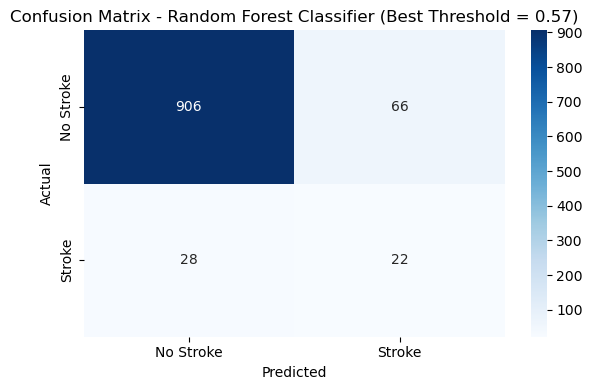

In [7]:
# 2) Plot confusion matrix for the BEST threshold
plt.figure(figsize=(6,4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Stroke", "Stroke"],
            yticklabels=["No Stroke", "Stroke"])
plt.title(f"Confusion Matrix - Random Forest Classifier (Best Threshold = {best_t})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [8]:
# from sklearn.inspection import permutation_importance

# # Compute permutation importance on test set using PR-AUC (better for imbalance)
# result = permutation_importance(
#     final_rf, X_test, y_test,
#     scoring="average_precision",  # PR-AUC
#     n_repeats=15, random_state=42, n_jobs=-1
# )

# imp = result.importances_mean
# indices = np.argsort(imp)[::-1][:10]

# top_features = X.columns[indices]
# top_values = imp[indices]

# print("Top 10 Important Features (RF - Permutation Importance):")
# for name, val in zip(top_features, top_values):
#     print(f"{name}: {val:.3f}")

# plt.figure(figsize=(10, 6))
# colors = plt.cm.tab10(np.linspace(0, 1, len(top_features)))
# plt.barh(top_features, top_values, color=colors)
# plt.xlabel("Permutation Importance (ΔPR-AUC)")
# plt.title("Top 10 Feature Importances — Random Forest (Permutation)")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()


Top 10 Important Features (RFC - Permutation Importance):
age: 0.148
avg_glucose_level: 0.040
work_type_Self-employed: 0.006
work_type_Government: 0.005
diabetes_category_Normal: 0.005
heart_disease_Yes: 0.003
smoking_status_Smoker: 0.002
age_group_35-39: 0.000
age_group_70-74: 0.000
bmi_category_Underweight: 0.000


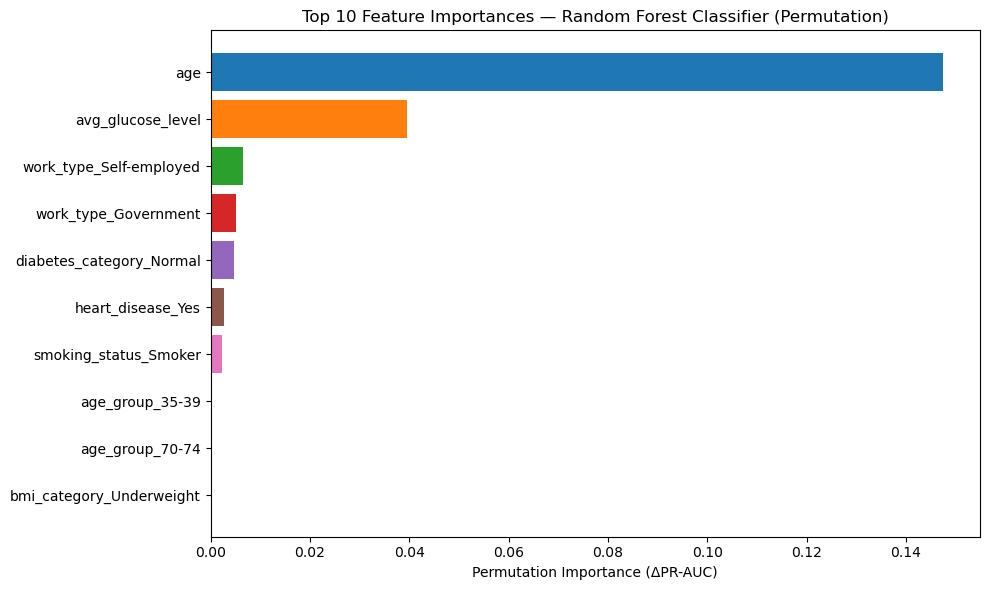

In [9]:
# Compute permutation importance on test set using PR-AUC (better for imbalance) instead of ROC
result = permutation_importance(
    final_rf, X_test, y_test,
    scoring="average_precision",  # PR-AUC
    n_repeats=15, random_state=42, n_jobs=-1
)

imp = result.importances_mean
indices = np.argsort(imp)[::-1][:10]

top_features = X.columns[indices]
top_values = imp[indices]

print("Top 10 Important Features (RFC - Permutation Importance):")
for name, val in zip(top_features, top_values):
    print(f"{name}: {val:.3f}")

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(top_features)))
plt.barh(top_features, top_values, color=colors)
plt.xlabel("Permutation Importance (ΔPR-AUC)")
plt.title("Top 10 Feature Importances — Random Forest Classifier (Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
# importances = best_rf.feature_importances_

# # Get feature names from X
# feature_names = X.columns

# indices = np.argsort(importances)[::-1]

# # Sort and take top 10
# indices = np.argsort(importances)[::-1][:10]
# top_features = feature_names[indices]
# top_values = importances[indices]

# # --- Print Top 10 ---
# print("Top 10 Important Features:")
# for name, val in zip(top_features, top_values):
#     print(f"{name}: {val:.3f}")

# # --- Plot Top 10 with Unique Colors ---
# plt.figure(figsize=(10, 6))
# colors = plt.cm.tab10(np.linspace(0, 1, len(top_features)))  # 10 distinct colors

# plt.barh(top_features, top_values, color=colors)
# plt.xlabel("Feature Importance")
# plt.title("Top 10 Feature Importances (Random Forest)")
# plt.gca().invert_yaxis()  # highest importance on top
# plt.tight_layout()
# plt.show()

## <font color='red'>Deep Learning (MLP)</font>

In [11]:
# ============================
# Baseline vs Tuned MLP (Loss curves + Test metrics)
# ============================
# ----------------------------
# Reproducibility
# ----------------------------
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

# ----------------------------
# Class weights
# ----------------------------
try:
    class_weight  # noqa: F401
except NameError:
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    class_weight = {0: 1.0, 1: float(neg) / float(pos)} if pos > 0 else {0:1.0, 1:1.0}
print("Class weights:", class_weight)

# ----------------------------
# Model factory
# ----------------------------
def build_mlp(units=(128, 64, 32), drop=(0.3, 0.3, 0.2), lr=0.003, d=None):
    if d is None:
        d = X_train.shape[1]
    inputs = layers.Input(shape=(d,))
    x = layers.Dense(units[0], activation="relu")(inputs); x = layers.BatchNormalization()(x); x = layers.Dropout(drop[0])(x)
    x = layers.Dense(units[1], activation="relu")(x);      x = layers.BatchNormalization()(x); x = layers.Dropout(drop[1])(x)
    x = layers.Dense(units[2], activation="relu")(x);      x = layers.BatchNormalization()(x); x = layers.Dropout(drop[2])(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(curve="ROC", name="AUC_ROC"),
                 keras.metrics.AUC(curve="PR",  name="AUC_PR")]
    )
    return model

# Shared callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_AUC_PR", mode="max", patience=15, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_AUC_PR", mode="max", factor=0.5, patience=7, min_lr=0.0005
)

# ----------------------------
# 1) BASELINE TRAIN
# ----------------------------
baseline_cfg = dict(units=(128,64,32), drop=(0.3,0.3,0.2), lr=0.003, batch_size=256, epochs=200, val_split=0.1)
tf.keras.backend.clear_session()
baseline_model = build_mlp(units=baseline_cfg["units"], drop=baseline_cfg["drop"], lr=baseline_cfg["lr"])
history_baseline = baseline_model.fit(
    X_train, y_train,
    validation_split=baseline_cfg["val_split"],
    epochs=baseline_cfg["epochs"],
    batch_size=baseline_cfg["batch_size"],
    verbose=1,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr]
)

# ----------------------------
# 2) SIMPLE TUNING (select by max val_AUC_PR)
# ----------------------------
search_space = [
    # (units,            dropout,            lr,     batch_size)
    ((128, 64, 32),     (0.3, 0.3, 0.2),    0.003,  256),
    ((256, 128, 64),    (0.4, 0.3, 0.2),    0.003,  256),
    ((256, 128, 64),    (0.4, 0.3, 0.2),    0.001,  256),
    ((128, 64, 32),     (0.5, 0.4, 0.3),    0.001,  512),
    ((192, 96, 48),     (0.4, 0.3, 0.2),    0.002,  256),
]

best_score = -np.inf
best_cfg = None
best_model_tuned = None
best_hist = None

for units, drop, lr, bs in search_space:
    tf.keras.backend.clear_session()
    model = build_mlp(units=units, drop=drop, lr=lr)
    hist = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=200,
        batch_size=bs,
        verbose=0,
        class_weight=class_weight,
        callbacks=[early_stop, reduce_lr]
    )
    score = float(np.max(hist.history["val_AUC_PR"]))  # select by best val_AUC_PR achieved
    best_epoch = int(np.argmax(hist.history["val_AUC_PR"])) + 1 # +1 for human-readable index
    
    if score > best_score:
        best_score = score
        best_cfg = dict(units=units, drop=drop, lr=lr, batch_size=bs, best_epoch=best_epoch)
        best_model_tuned = model
        best_hist = hist

print("Best tuned config:", best_cfg)
print(f"Best val_AUC_PR: {best_score:.3f}")

# ----------------------------
# 3) REFIT TUNED MODEL (fresh history for clean plots)
# ----------------------------
tf.keras.backend.clear_session()
final_tuned_model = build_mlp(**{k: best_cfg[k] for k in ["units","drop","lr"]})
history_tuned = final_tuned_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=best_cfg["batch_size"],
    verbose=1,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr]
)

Class weights: {0: 1.0, 1: 19.537688442211056}

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC_PR: 0.0976 - AUC_ROC: 0.6684 - loss: 1.3964 - val_AUC_PR: 0.1664 - val_AUC_ROC: 0.8120 - val_loss: 0.4907 - learning_rate: 0.0030
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC_PR: 0.1708 - AUC_ROC: 0.8079 - loss: 1.0805 - val_AUC_PR: 0.2043 - val_AUC_ROC: 0.8179 - val_loss: 0.4293 - learning_rate: 0.0030
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC_PR: 0.1673 - AUC_ROC: 0.8215 - loss: 1.0094 - val_AUC_PR: 0.2268 - val_AUC_ROC: 0.8361 - val_loss: 0.3976 - learning_rate: 0.0030
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC_PR: 0.1975 - AUC_ROC: 0.8443 - loss: 0.9313 - val_AUC_PR: 0.1941 - val_AUC_ROC: 0.8465 - val_loss: 0.3777 - learning_rate: 0.0030
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC_PR: 0.1958 - AUC_ROC: 0.8412 - loss: 0.9272 - val_AUC_PR: 0.1892 - val_AUC_ROC: 0.8449 - val_loss: 0.3605 - learning_rate: 0.0030
Epoch 6/200
15/

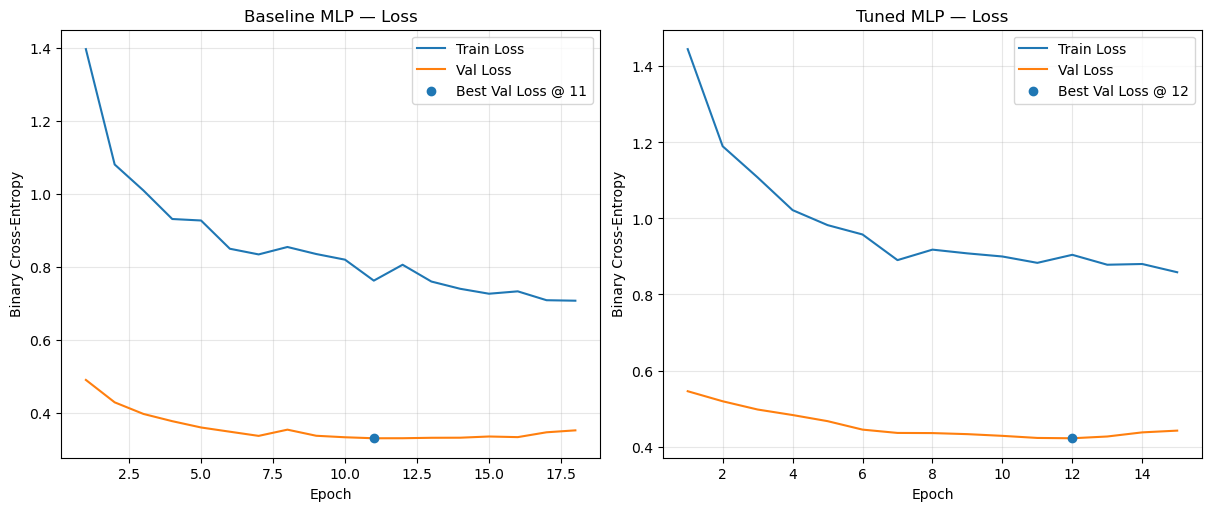

Baseline  ROC-AUC: 0.819 | PR-AUC: 0.166
Tuned     ROC-AUC: 0.817 | PR-AUC: 0.218
Baseline  best F1=0.323 @ thr=0.57
Tuned     best F1=0.289 @ thr=0.56


In [12]:
# ----------------------------
# 4) PLOT: Baseline vs Tuned (Loss)
# ----------------------------
def _plot_loss(ax, hist, title):
    loss = hist.history["loss"]; vloss = hist.history["val_loss"]
    e = np.arange(1, len(loss)+1)
    ax.plot(e, loss, label="Train Loss")
    ax.plot(e, vloss, label="Val Loss")
    be = int(np.argmin(vloss)) + 1
    ax.scatter([be], [vloss[be-1]], zorder=3, label=f"Best Val Loss @ {be}")
    ax.set_title(title); ax.set_xlabel("Epoch"); ax.set_ylabel("Binary Cross-Entropy")
    ax.grid(alpha=0.3); ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
_plot_loss(axes[0], history_baseline, "Baseline MLP — Loss")
_plot_loss(axes[1], history_tuned,    "Tuned MLP — Loss")
plt.show()

# ----------------------------
# 5) TEST-SET COMPARISON (ROC/PR)
# ----------------------------
p_base = baseline_model.predict(X_test, verbose=0).ravel()
p_tuned = final_tuned_model.predict(X_test, verbose=0).ravel()

print(f"Baseline  ROC-AUC: {roc_auc_score(y_test, p_base):.3f} | PR-AUC: {average_precision_score(y_test, p_base):.3f}")
print(f"Tuned     ROC-AUC: {roc_auc_score(y_test, p_tuned):.3f} | PR-AUC: {average_precision_score(y_test, p_tuned):.3f}")

# (Optional) quick threshold selection by F1 for both (show how tuning impacted operating point)
def best_f1_threshold(y_true, p):
    prec, rec, thr = precision_recall_curve(y_true, p)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])

b_thr, b_f1 = best_f1_threshold(y_test, p_base)
t_thr, t_f1 = best_f1_threshold(y_test, p_tuned)
print(f"Baseline  best F1={b_f1:.3f} @ thr={b_thr:.2f}")
print(f"Tuned     best F1={t_f1:.3f} @ thr={t_thr:.2f}")

ROC-AUC (Baseline): 0.819
ROC-AUC (Tuned): 0.817
PR-AUC (Baseline): 0.166
PR-AUC (Tuned): 0.218



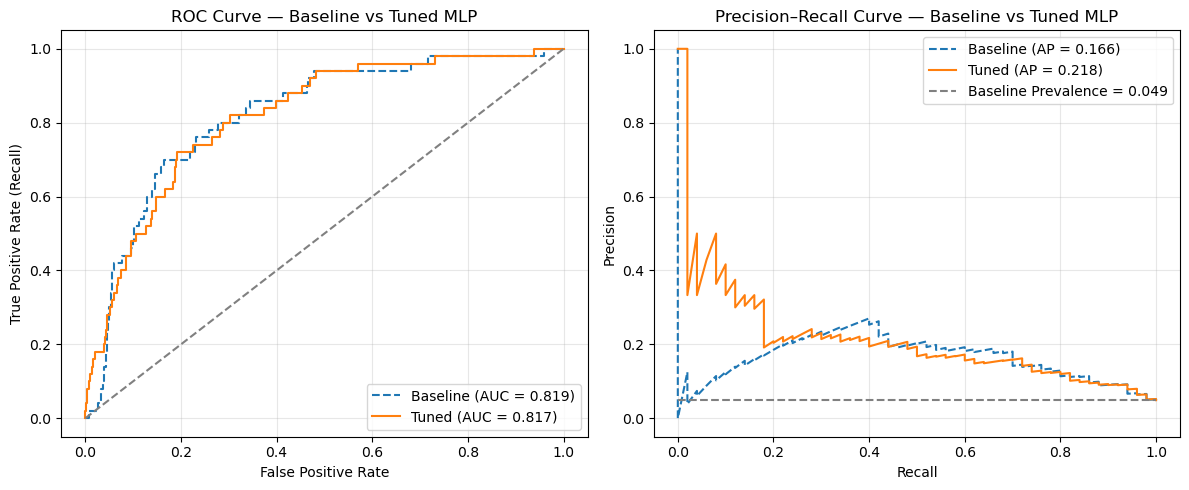

In [13]:
# --- Predict probabilities ---
p_base  = baseline_model.predict(X_test, verbose=0).ravel()
p_tuned = final_tuned_model.predict(X_test, verbose=0).ravel()

# --- Compute metrics ---
roc_base  = roc_auc_score(y_test, p_base)
roc_tuned = roc_auc_score(y_test, p_tuned)

pr_base   = average_precision_score(y_test, p_base)
pr_tuned  = average_precision_score(y_test, p_tuned)

# --- ROC data ---
fpr_base,  tpr_base,  _ = roc_curve(y_test, p_base)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, p_tuned)

# --- PR data (+ baseline positive prevalence) ---
prec_base,  rec_base,  _ = precision_recall_curve(y_test, p_base)
prec_tuned, rec_tuned, _ = precision_recall_curve(y_test, p_tuned)
pos_rate = (y_test == 1).mean()

print(f"ROC-AUC (Baseline): {roc_base:.3f}")
print(f"ROC-AUC (Tuned): {roc_tuned:.3f}")
print(f"PR-AUC (Baseline): {pr_base:.3f}")
print(f"PR-AUC (Tuned): {pr_tuned:.3f}\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# ================= ROC PLOT =================
axes[0].plot(fpr_base, tpr_base, linestyle="--", label=f"Baseline (AUC = {roc_base:.3f})")
axes[0].plot(fpr_tuned, tpr_tuned, linestyle="-", label=f"Tuned (AUC = {roc_tuned:.3f})")
axes[0].plot([0,1], [0,1], linestyle="--", color="gray")
axes[0].set_title("ROC Curve — Baseline vs Tuned MLP")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# ================= PR PLOT =================
axes[1].plot(rec_base, prec_base, linestyle="--", label=f"Baseline (AP = {pr_base:.3f})")
axes[1].plot(rec_tuned, prec_tuned, linestyle="-", label=f"Tuned (AP = {pr_tuned:.3f})")
axes[1].hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"Baseline Prevalence = {pos_rate:.3f}")
axes[1].set_title("Precision–Recall Curve — Baseline vs Tuned MLP")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(loc="upper right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# --- Find exact best threshold (NO rounding) ---
prec_t, rec_t, thr_t = precision_recall_curve(y_test, p_tuned)
f1_curve = (2 * prec_t[:-1] * rec_t[:-1]) / (prec_t[:-1] + rec_t[:-1] + 1e-12)
best_idx_t = int(np.nanargmax(f1_curve))
best_thr_exact = float(thr_t[best_idx_t])      # keep exact
best_f1_exact  = float(f1_curve[best_idx_t])

# Evaluate at EXACT best threshold (use >= consistently)
y_pred_best = (p_tuned >= best_thr_exact).astype(int)
acc_best = accuracy_score(y_test, y_pred_best)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, average='binary', zero_division=0
)
cm_best = confusion_matrix(y_test, y_pred_best, labels=[0,1])

# Print (display rounded, but DO NOT round the value used)
print("\n=== Tuned MLP Best Threshold Selection ===")
print(f"Best Threshold = {best_thr_exact:.2f}")   # print nice
print(f"F1 (Positive Class) = {f1_best:.3f}")     # now matches
print(f"Accuracy = {acc_best:.3f}\n")
print("Confusion Matrix — Tuned MLP (Best Threshold):")
print(cm_best, "\n")

# ===== Threshold Sweep (including the EXACT best value) =====
print("\n===== Tuned MLP: Testing Different Decision Thresholds =====")

# Build 0.00..1.00 grid and explicitly add the exact best threshold (no rounding)
grid = np.round(np.arange(0.00, 1.01, 0.01), 2)
thr_grid = np.unique(np.r_[grid, best_thr_exact])  # keep exact in the set

def _metrics_at_thr(t):
    yhat = (p_tuned >= t).astype(int)  # same comparator as above
    acc  = accuracy_score(y_test, yhat)
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, yhat, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_test, yhat, labels=[0,1])
    return acc, p, r, f1, cm

for t in thr_grid:
    acc_t, p_t, r_t, f1_t, cm_t = _metrics_at_thr(t)
    print(f"\n=== Threshold = {t:.2f} ===")
    print(f"Acc: {acc_t:.3f} | Prec: {p_t:.3f} | Rec: {r_t:.3f} | F1: {f1_t:.3f}")
    print("Confusion Matrix:\n", cm_t)


=== Tuned MLP Best Threshold Selection ===
Best Threshold = 0.56
F1 (Positive Class) = 0.289
Accuracy = 0.885

Confusion Matrix — Tuned MLP (Best Threshold):
[[880  92]
 [ 26  24]] 


===== Tuned MLP: Testing Different Decision Thresholds =====

=== Threshold = 0.00 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.01 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.02 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.03 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.04 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.05 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.06 ===
Acc: 0.049 | Prec: 0

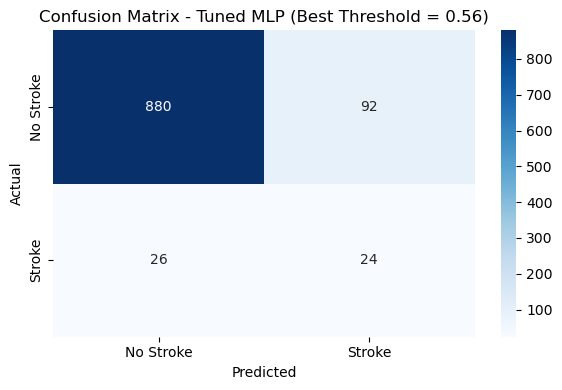

In [15]:
# --- Confusion Matrix (Tuned MLP @ Best Threshold) ---
plt.figure(figsize=(6,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Stroke", "Stroke"],
            yticklabels=["No Stroke", "Stroke"])
plt.title(f"Confusion Matrix - Tuned MLP (Best Threshold = {best_thr_exact:.2f})")
plt.xlabel("Predicted"); 
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Top 10 Important Features — Tuned MLP (Permutation):
heart_disease_Yes: 0.041
age: 0.033
age_group_80+: 0.027
age_group_75-79: 0.023
diabetes_category_Prediabetic: 0.022
work_type_Government: 0.022
age_group_70-74: 0.022
age_group_10-14: 0.022
age_group_55-59: 0.020
age_group_5-9: 0.019


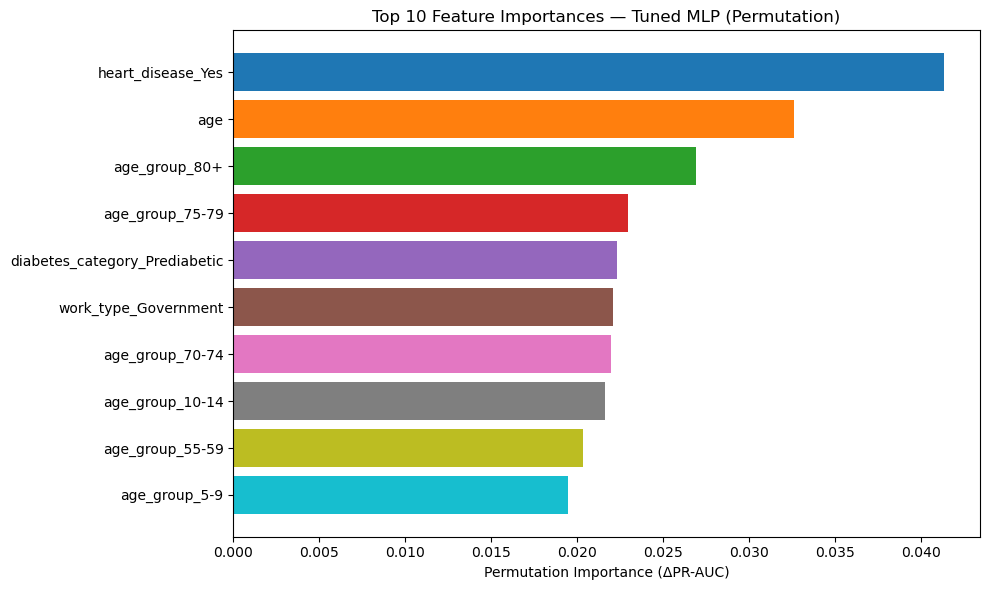

In [16]:
# ==========================================
# Permutation Importance — Tuned MLP
# (importance = drop in PR-AUC when permuted)
# ==========================================

USE_PRAUC = True  # keep PR-AUC since dataset is imbalanced

def _score_tuned(Xb):
    p = final_tuned_model.predict(Xb, verbose=0).ravel()
    if USE_PRAUC:
        return float(average_precision_score(y_test, p))
    # Alternative scoring: F1 at tuned best threshold
    yhat = (p >= best_thr_exact).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(
        y_test, yhat, average="binary", zero_division=0
    )
    return float(f1)

# Baseline score on unshuffled features
base_score_tuned = _score_tuned(X_test)

feat_names = np.array(list(X.columns))
drops_tuned = np.zeros(X_test.shape[1], dtype=float)
rng = np.random.default_rng(42)

# Permutation loop
for j in range(X_test.shape[1]):
    Xp = X_test.copy()
    Xp[:, j] = rng.permutation(Xp[:, j])
    drops_tuned[j] = base_score_tuned - _score_tuned(Xp)

# Top 10 features
indices_tuned = np.argsort(drops_tuned)[::-1][:10]
top_features_tuned = feat_names[indices_tuned]
top_values_tuned   = drops_tuned[indices_tuned]

label_x = "Permutation Importance (ΔPR-AUC)" if USE_PRAUC else "Permutation Importance (ΔF1@thr)"

print("\nTop 10 Important Features — Tuned MLP (Permutation):")
for name, val in zip(top_features_tuned, top_values_tuned):
    print(f"{name}: {val:.3f}")

# Plot
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(top_features_tuned)))
plt.barh(top_features_tuned, top_values_tuned, color=colors)
plt.xlabel(label_x)
plt.title("Top 10 Feature Importances — Tuned MLP (Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [17]:
# ----------------------------
# Helpers
# ----------------------------
def best_f1_threshold_from_proba(y_true, proba):
    """Return exact threshold (no rounding) that maximizes F1 for the positive class."""
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])

def evaluate_at_threshold(y_true, proba, thr):
    """Compute metrics and confusion matrix when classifying with (proba >= thr)."""
    yhat = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, yhat, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_true, yhat, labels=[0,1])
    roc = roc_auc_score(y_true, proba)
    pr  = average_precision_score(y_true, proba)  # PR-AUC (Average Precision)
    return acc, prec, rec, f1, roc, pr, cm

# ----------------------------
# Inputs expected to exist:
#   y_test     : array-like of shape (n_samples,)
#   y_proba    : RF predicted probabilities for positive class (from final_rf)
#   p_tuned    : tuned MLP predicted probabilities for positive class
# ----------------------------

# --- 1) Find exact best thresholds (no rounding) ---
rf_thr,  rf_f1_best  = best_f1_threshold_from_proba(y_test, y_proba)
mlp_thr, mlp_f1_best = best_f1_threshold_from_proba(y_test, p_tuned)

# --- 2) Evaluate both models at their own best thresholds ---
rf_acc, rf_prec, rf_rec, rf_f1, rf_roc, rf_pr, rf_cm   = evaluate_at_threshold(y_test, y_proba, rf_thr)
mlp_acc, mlp_prec, mlp_rec, mlp_f1, mlp_roc, mlp_pr, mlp_cm = evaluate_at_threshold(y_test, p_tuned, mlp_thr)

rf_tn, rf_fp, rf_fn, rf_tp     = rf_cm.ravel()
mlp_tn, mlp_fp, mlp_fn, mlp_tp = mlp_cm.ravel()

# --- 3) Tidy comparison table ---
summary = pd.DataFrame({
    "Best Threshold": [rf_thr, mlp_thr],
    "Accuracy":       [rf_acc, mlp_acc],
    "Precision":      [rf_prec, mlp_prec],
    "Recall":         [rf_rec, mlp_rec],
    "F1":             [rf_f1,  mlp_f1],
    "ROC-AUC":        [rf_roc, mlp_roc],
    "PR-AUC":         [rf_pr,  mlp_pr],
    "TN":             [rf_tn,  mlp_tn],
    "FP":             [rf_fp,  mlp_fp],
    "FN":             [rf_fn,  mlp_fn],
    "TP":             [rf_tp,  mlp_tp],
}, index=["Random Forest Classifier", "Tuned MLP"])

with pd.option_context("display.precision", 3):
    print("\n=== Best-Threshold Summary (RFC vs Tuned MLP) ===")
    print(summary)

# Concise one-liners (nice for logs)
print(
    f"\nRFC  @ {rf_thr:.2f} → Acc={rf_acc:.3f}, P={rf_prec:.3f}, R={rf_rec:.3f}, "
    f"F1={rf_f1:.3f}, ROC-AUC={rf_roc:.3f}, PR-AUC={rf_pr:.3f}, CM={rf_cm.tolist()}"
)
print(
    f"MLP* @ {mlp_thr:.2f} → Acc={mlp_acc:.3f}, P={mlp_prec:.3f}, R={mlp_rec:.3f}, "
    f"F1={mlp_f1:.3f}, ROC-AUC={mlp_roc:.3f}, PR-AUC={mlp_pr:.3f}, CM={mlp_cm.tolist()}"
)


=== Best-Threshold Summary (RFC vs Tuned MLP) ===
                          Best Threshold  Accuracy  Precision  Recall     F1  \
Random Forest Classifier           0.575     0.911      0.259    0.44  0.326   
Tuned MLP                          0.561     0.885      0.207    0.48  0.289   

                          ROC-AUC  PR-AUC   TN  FP  FN  TP  
Random Forest Classifier    0.819   0.216  909  63  28  22  
Tuned MLP                   0.817   0.218  880  92  26  24  

RFC  @ 0.57 → Acc=0.911, P=0.259, R=0.440, F1=0.326, ROC-AUC=0.819, PR-AUC=0.216, CM=[[909, 63], [28, 22]]
MLP* @ 0.56 → Acc=0.885, P=0.207, R=0.480, F1=0.289, ROC-AUC=0.817, PR-AUC=0.218, CM=[[880, 92], [26, 24]]


In [18]:
# # Reproducibility
# SEED = 42
# np.random.seed(SEED); tf.random.set_seed(SEED)

# # --- Class weights for imbalance ---
# neg = (y_train == 0).sum()
# pos = (y_train == 1).sum()
# class_weight = {0: 1.0, 1: float(neg) / float(pos)} if pos > 0 else {0:1.0, 1:1.0}
# print("Class weights:", class_weight)

# # --- Build model ---
# inp_dim = X_train.shape[1]
# def build_model(d=inp_dim):
#     inputs = layers.Input(shape=(d,))
#     x = layers.Dense(128, activation="relu")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.3)(x)

#     x = layers.Dense(64, activation="relu")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.3)(x)

#     x = layers.Dense(32, activation="relu")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.2)(x)

#     outputs = layers.Dense(1, activation="sigmoid")(x)
#     model = keras.Model(inputs, outputs)
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.003),
#         loss="binary_crossentropy",
#         metrics=[keras.metrics.AUC(curve="ROC", name="AUC_ROC"),
#                  keras.metrics.AUC(curve="PR",  name="AUC_PR")]
#     )
#     return model


# dl_model = build_model()

# early_stop = keras.callbacks.EarlyStopping(
#     monitor="val_AUC_PR", mode="max", patience=15, restore_best_weights=True
# )
# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor="val_AUC_PR", mode="max", factor=0.5, patience=7, min_lr=0.001
# )

# history = dl_model.fit(
#     X_train, y_train,
#     validation_split=0.1,
#     epochs=200,
#     batch_size=256,
#     verbose=1,
#     class_weight=class_weight,
#     callbacks=[early_stop, reduce_lr]
# )

In [19]:
# # ============================
# # Plot Train vs Validation Loss
# # ============================
# hist = history.history
# epochs = range(1, len(hist["loss"]) + 1)

# plt.figure(figsize=(6,4))
# plt.plot(epochs, hist["loss"], label="Train Loss")
# plt.plot(epochs, hist["val_loss"], label="Val Loss")

# # Mark the best (lowest) validation loss
# best_epoch = int(np.argmin(hist["val_loss"])) + 1
# best_val = hist["val_loss"][best_epoch - 1]
# plt.scatter([best_epoch], [best_val], marker="o", zorder=3, label=f"Best Val Loss @ {best_epoch}")
# plt.xlabel("Epoch")
# plt.ylabel("Binary Cross-Entropy Loss")
# plt.title("Training vs Validation Loss")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

In [20]:
# # --- Evaluate on TEST ---
# p_test = dl_model.predict(X_test, verbose=0).ravel()
# roc = roc_auc_score(y_test, p_test)
# pr  = average_precision_score(y_test, p_test)
# print(f"MLP ROC-AUC={roc:.3f}")
# print(f"MLP PR-AUC={pr:.3f}")

# # ================
# # Visualize ROC & PR
# # ================

# # ROC data
# fpr, tpr, _ = roc_curve(y_test, p_test)

# # PR data (+ baseline = prevalence)
# prec_curve, rec_curve, _ = precision_recall_curve(y_test, p_test)
# pos_rate = (y_test == 1).mean()

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # --- ROC CURVE (LEFT) ---
# axes[0].plot(fpr, tpr, label=f"AUC = {roc:.3f}")
# axes[0].plot([0,1], [0,1], linestyle="--", color="gray")
# axes[0].set_title("ROC Curve — MLP")
# axes[0].set_xlabel("False Positive Rate")
# axes[0].set_ylabel("True Positive Rate (Recall)")
# axes[0].legend(loc="lower right")
# axes[0].grid(alpha=0.3)

# # --- PR CURVE (RIGHT) ---
# axes[1].plot(rec_curve, prec_curve, label=f"AP = {pr:.3f}")
# axes[1].hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"Baseline = {pos_rate:.3f}")
# axes[1].set_title("Precision Recall Curve — MLP")
# axes[1].set_xlabel("Recall")
# axes[1].set_ylabel("Precision")
# axes[1].legend(loc="upper right")
# axes[1].grid(alpha=0.3)

# plt.tight_layout()
# plt.show()

In [21]:
# # --- Pick BEST threshold by F1(positive) ---
# prec, rec, thr = precision_recall_curve(y_test, p_test)
# f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
# best_idx = np.nanargmax(f1)
# best_thr = round(float(thr[best_idx]), 2)
# best_f1 = f1[best_idx]

# # Predictions at best threshold
# y_pred_best = (p_test >= best_thr).astype(int)

# # Performance metrics
# acc = accuracy_score(y_test, y_pred_best)
# prec_best, rec_best, _, _ = precision_recall_fscore_support(
#     y_test, y_pred_best, average='binary', zero_division=0
# )

# # Show exact best, with more decimals so you see the *true* value
# print(f"Best Threshold = {best_thr:.2f} (F1 = {best_f1:.3f})")
# print(f"Accuracy: {acc:.3f}\n")

# print("Confusion Matrix - MLP (Best Threshold):")
# cm = confusion_matrix(y_test, y_pred_best)
# print(cm, "\n")

# print("Classification Report - MLP (Best Threshold):")
# print(classification_report(
#     y_test, y_pred_best,
#     target_names=["No Stroke", "Stroke"],
#     digits=3
# ))

# # ===== Testing Different Decision Thresholds =====
# print("\n===== Testing Different Decision Thresholds =====")

# # Add the exact best threshold into your grid and deduplicate
# # Include best_thr into the list
# test_thresholds = sorted(set(np.append(np.round(np.arange(0.00, 1.01, 0.01), 2), best_thr)))

# for t in test_thresholds:
#     y_pred_t = (p_test >= t).astype(int)
#     acc_t = accuracy_score(y_test, y_pred_t)
#     p_t, r_t, f1_t, _ = precision_recall_fscore_support(
#         y_test, y_pred_t, average="binary", zero_division=0
#     )
#     cm_t = confusion_matrix(y_test, y_pred_t)

#     print(f"\n=== Threshold = {t:.2f}")
#     print(f"Acc: {acc_t:.3f} | Prec: {p_t:.3f} | Rec: {r_t:.3f} | F1: {f1_t:.3f}")
#     print("Confusion Matrix:\n", cm_t)

In [22]:
# # --- Confusion matrix (For best threshold) ---
# plt.figure(figsize=(6,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=["No Stroke", "Stroke"],
#             yticklabels=["No Stroke", "Stroke"])
# plt.title(f"Confusion Matrix — Neural Net (Best Threshold = {best_thr:.2f})")
# plt.xlabel("Predicted"); plt.ylabel("Actual")
# plt.tight_layout(); plt.show()

In [23]:
# # ==========================================
# # MLP "Feature Importances" via Permutation
# # (importance = drop in PR-AUC when permuted)
# # ==========================================

# # Preconditions:
# # - dl_model   : trained Keras model with sigmoid output
# # - X_test     : numpy array (scaled, one-hot applied)
# # - y_test     : 1D array/Series of 0/1
# # - X.columns  : original feature names
# # - best_thr   : your MLP best threshold from earlier code

# # ---- Choose scoring for importance (PR-AUC recommended) ----
# USE_PRAUC = True  # set to False to use F1 at best_thr instead

# def _score(Xb):
#     p = dl_model.predict(Xb, verbose=0).ravel()
#     if USE_PRAUC:
#         return float(average_precision_score(y_test, p))
#     # F1@best_thr (alternative)
#     yhat = (p >= best_thr).astype(int)
#     _, _, f1, _ = precision_recall_fscore_support(
#         y_test, yhat, average="binary", zero_division=0
#     )
#     return float(f1)

# # Baseline score
# base_score = _score(X_test)

# # Permute each column and measure score drop
# feat_names = np.array(list(X.columns))
# drops = np.zeros(X_test.shape[1], dtype=float)
# rng = np.random.default_rng(42)

# for j in range(X_test.shape[1]):
#     Xp = X_test.copy()
#     Xp[:, j] = rng.permutation(Xp[:, j])
#     drops[j] = base_score - _score(Xp)

# # ---- Top 10 like your RF code ----
# indices = np.argsort(drops)[::-1][:10]
# top_features = feat_names[indices]
# top_values   = drops[indices]

# label_x = "Permutation Importance (ΔPR-AUC)" if USE_PRAUC else "Permutation Importance (ΔF1@thr)"

# print("Top 10 Important Features (MLP, permutation):")
# for name, val in zip(top_features, top_values):
#     print(f"{name}: {val:.3f}")

# plt.figure(figsize=(10, 6))
# colors = plt.cm.tab10(np.linspace(0, 1, len(top_features)))  # 10 distinct colors
# plt.barh(top_features, top_values, color=colors)
# plt.xlabel(label_x)
# plt.title("Top 10 Feature Importances — MLP (Permutation)")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()


In [24]:
# rf_best_thr = float(best_t)
# rf_pred_best = (y_proba >= rf_best_thr).astype(int)
# rf_cm = confusion_matrix(y_test, rf_pred_best, labels=[0,1])
# rf_tn, rf_fp, rf_fn, rf_tp = rf_cm.ravel()
# rf_acc = accuracy_score(y_test, rf_pred_best)
# rf_prec, rf_rec, rf_f1, _ = precision_recall_fscore_support(
#     y_test, rf_pred_best, average='binary', zero_division=0
# )
# rf_roc = roc_auc_score(y_test, y_proba)
# rf_pr  = average_precision_score(y_test, y_proba)

# # --- Recompute/capture MLP-at-best-threshold safely ---
# # Assumes you still have:
# #   p_test     : MLP predicted probs for positive class
# #   best_thr   : MLP best threshold you found
# mlp_best_thr = float(best_thr)
# mlp_pred_best = (p_test >= mlp_best_thr).astype(int)
# mlp_cm = confusion_matrix(y_test, mlp_pred_best, labels=[0,1])
# mlp_tn, mlp_fp, mlp_fn, mlp_tp = mlp_cm.ravel()
# mlp_acc = accuracy_score(y_test, mlp_pred_best)
# mlp_prec, mlp_rec, mlp_f1, _ = precision_recall_fscore_support(
#     y_test, mlp_pred_best, average='binary', zero_division=0
# )
# mlp_roc = roc_auc_score(y_test, p_test)
# mlp_pr  = average_precision_score(y_test, p_test)

# # --- Put everything in one tidy table ---
# summary = pd.DataFrame({
#     "Best Threshold": [rf_best_thr, mlp_best_thr],
#     "Accuracy":       [rf_acc, mlp_acc],
#     "Precision":      [rf_prec, mlp_prec],
#     "Recall":         [rf_rec, mlp_rec],
#     "F1":             [rf_f1, mlp_f1],
#     "ROC-AUC":        [rf_roc, mlp_roc],
#     "PR-AUC":         [rf_pr,  mlp_pr],
#     "TN":             [rf_tn,  mlp_tn],
#     "FP":             [rf_fp,  mlp_fp],
#     "FN":             [rf_fn,  mlp_fn],
#     "TP":             [rf_tp,  mlp_tp],
# }, index=["Random Forest", "Neural Net (MLP)"])

# # Pretty print with sensible rounding
# with pd.option_context("display.precision", 3):
#     print("\n=== Best-Threshold Summary (RF vs MLP) ===")
#     print(summary)

# # Optional: concise human-readable one-liners
# print(
#     f"\nRF  @ {rf_best_thr:.2f} → Acc={rf_acc:.3f}, P={rf_prec:.3f}, R={rf_rec:.3f}, "
#     f"F1={rf_f1:.3f}, ROC-AUC={rf_roc:.3f}, PR-AUC={rf_pr:.3f}, CM={rf_cm.tolist()}"
# )
# print(
#     f"MLP @ {mlp_best_thr:.2f} → Acc={mlp_acc:.3f}, P={mlp_prec:.3f}, R={mlp_rec:.3f}, "
#     f"F1={mlp_f1:.3f}, ROC-AUC={mlp_roc:.3f}, PR-AUC={mlp_pr:.3f}, CM={mlp_cm.tolist()}"
# )

## <font color='red'>Ensemble</font>

### <font color='blue'>Stack</font>

In [25]:
# ============================
# Ensemble: Stacked RF + MLP
# ============================
from sklearn.linear_model import LogisticRegression

# ---- Helpers (reuse your style) ----
def _best_f1_threshold(y_true, proba):
    p, r, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * p[:-1] * r[:-1]) / (p[:-1] + r[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])

def _evaluate_at_thr(y_true, proba, thr):
    yhat = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, yhat, average="binary", zero_division=0)
    cm = confusion_matrix(y_true, yhat, labels=[0,1])
    return acc, prec, rec, f1, cm

# ---- Ensure best_cfg exists for building the MLP in CV ----
if "best_cfg" not in globals():
    best_cfg = {'units': (256,128,64), 'drop': (0.4,0.3,0.2), 'lr': 0.001, 'batch_size': 256}

# ---- Get OOF probabilities for stacking (no test leakage) ----
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_rf  = np.zeros_like(y_train, dtype=float)
oof_mlp = np.zeros_like(y_train, dtype=float)

for tr_idx, va_idx in kf.split(X_train, y_train):
    X_tr, X_va = X_train[tr_idx], X_train[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]  # y_train is a Series

    # RF fold model
    rf_fold = clone(final_rf)
    rf_fold.fit(X_tr, y_tr)
    oof_rf[va_idx] = rf_fold.predict_proba(X_va)[:, 1]

    # MLP fold model
    tf.keras.backend.clear_session()
    mlp_fold = build_mlp(units=best_cfg['units'], drop=best_cfg['drop'], lr=best_cfg['lr'], d=X_tr.shape[1])
    mlp_fold.fit(
        X_tr, y_tr,
        validation_split=0.1,
        epochs=200,
        batch_size=best_cfg["batch_size"],
        verbose=0,
        class_weight=class_weight,
        callbacks=[early_stop, reduce_lr]
    )
    oof_mlp[va_idx] = mlp_fold.predict(X_va, verbose=0).ravel()

# ---- Train meta-learner on OOF stacks ----
X_oof_stack = np.column_stack([oof_rf, oof_mlp])
meta = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)
meta.fit(X_oof_stack, y_train)

# ---- Build test-time stack features using your final models ----
p_rf_test  = final_rf.predict_proba(X_test)[:, 1]
p_mlp_test = final_tuned_model.predict(X_test, verbose=0).ravel()
X_test_stack = np.column_stack([p_rf_test, p_mlp_test])

# ---- Ensemble probabilities from meta-learner ----
p_stack = meta.predict_proba(X_test_stack)[:, 1]

ROC-AUC (Stack) = 0.831
PR-AUC  (Stack) = 0.243


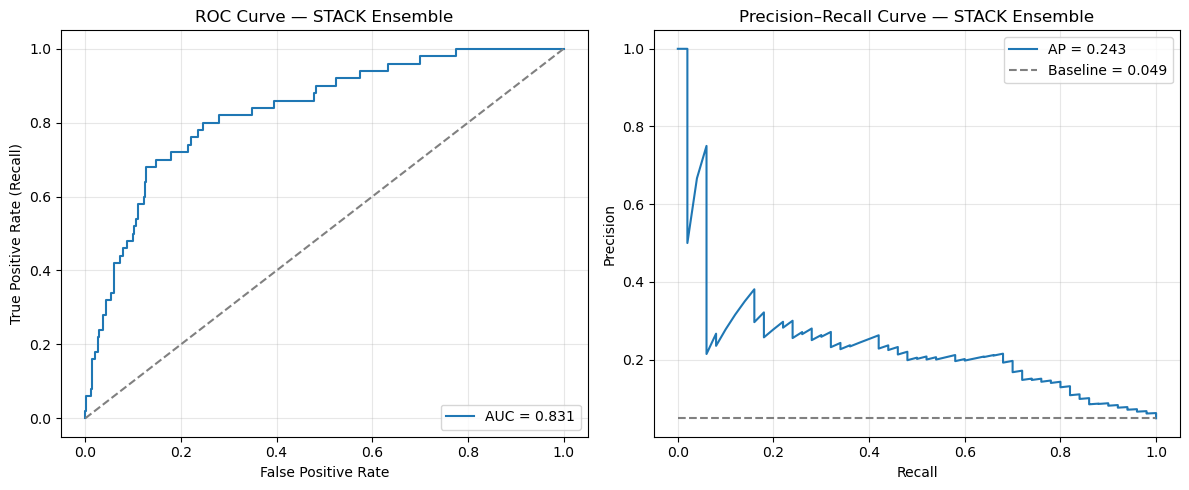

ROC-AUC (STACK) = 0.831
PR-AUC  (STACK) = 0.243


In [26]:
# ---- Report AUCs (same style) ----
roc_stack = roc_auc_score(y_test, p_stack)
pr_stack  = average_precision_score(y_test, p_stack)
print(f"ROC-AUC (Stack) = {roc_stack:.3f}")
print(f"PR-AUC  (Stack) = {pr_stack:.3f}")
# --- Compute curves ---
fpr_stack, tpr_stack, _ = roc_curve(y_test, p_stack)
prec_stk, rec_stk, _    = precision_recall_curve(y_test, p_stack)

# Positive class prevalence (for PR baseline)
pos_rate = (y_test == 1).mean()

plt.figure(figsize=(12,5))

# ===== ROC =====
plt.subplot(1,2,1)
plt.plot(fpr_stack, tpr_stack, label=f"AUC = {roc_stack:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curve — STACK Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# ===== PR =====
plt.subplot(1,2,2)
plt.plot(rec_stk, prec_stk, label=f"AP = {pr_stack:.3f}")
plt.hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--",
           label=f"Baseline = {pos_rate:.3f}")
plt.title("Precision–Recall Curve — STACK Ensemble")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# ---- Best F1 threshold for the positive class ----
best_thr_stack, best_f1_stack = _best_f1_threshold(y_test, p_stack)
acc_s, prec_s, rec_s, f1_s, cm_s = _evaluate_at_thr(y_test, p_stack, best_thr_stack)

print(f"\nBest Threshold (Stack) = {best_thr_stack:.2f} (F1 = {best_f1_stack:.3f})")
print(f"Accuracy: {acc_s:.3f}")
print("\nConfusion Matrix — STACK (Best Threshold):\n", cm_s)
print("\nClassification Report — STACK (Best Threshold):\n",
      classification_report(y_test, (p_stack >= best_thr_stack).astype(int),
                            target_names=["No Stroke","Stroke"], digits=3))


Best Threshold (Stack) = 0.67 (F1 = 0.327)
Accuracy: 0.863

Confusion Matrix — STACK (Best Threshold):
 [[848 124]
 [ 16  34]]

Classification Report — STACK (Best Threshold):
               precision    recall  f1-score   support

   No Stroke      0.981     0.872     0.924       972
      Stroke      0.215     0.680     0.327        50

    accuracy                          0.863      1022
   macro avg      0.598     0.776     0.625      1022
weighted avg      0.944     0.863     0.895      1022



In [28]:
# ============================
# Threshold Sweep (STACK)
# ============================

print("\n===== STACK: Threshold Sweep =====")
grid = np.round(np.arange(0.00, 1.01, 0.01), 2)

# Make sure the best threshold is included
thr_grid = np.unique(np.append(grid, best_thr_stack))

for t in thr_grid:
    y_hat_t = (p_stack >= t).astype(int)
    acc_t = accuracy_score(y_test, y_hat_t)
    p_t, r_t, f1_t, _ = precision_recall_fscore_support(
        y_test, y_hat_t, average="binary", zero_division=0
    )
    cm_t = confusion_matrix(y_test, y_hat_t, labels=[0,1])

    print(f"\n--- Threshold = {t:.2f} ---")
    print(f"Accuracy : {acc_t:.3f}")
    print(f"Precision: {p_t:.3f}")
    print(f"Recall   : {r_t:.3f}")
    print(f"F1-Score : {f1_t:.3f}")
    print("Confusion Matrix:")
    print(cm_t)



===== STACK: Threshold Sweep =====

--- Threshold = 0.00 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.01 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.02 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.03 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.04 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.05 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.06 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.

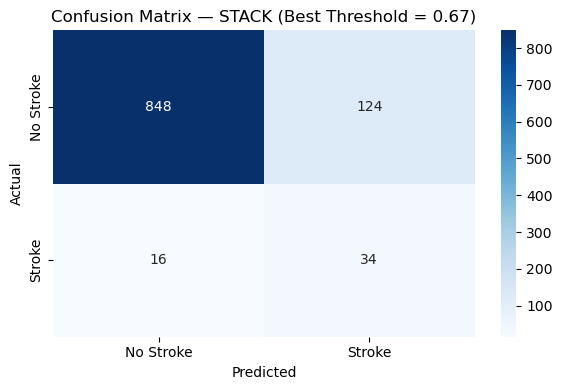

In [29]:
# ---- Plot confusion matrix (same look & feel) ----
plt.figure(figsize=(6,4))
sns.heatmap(cm_s, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Stroke","Stroke"], yticklabels=["No Stroke","Stroke"])
plt.title(f"Confusion Matrix — STACK (Best Threshold = {best_thr_stack:.2f})")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()


Top STACK Feature Contributions (Meta-Learner Coefficients):
RF Probability: 4.4784
MLP Probability: 3.7233


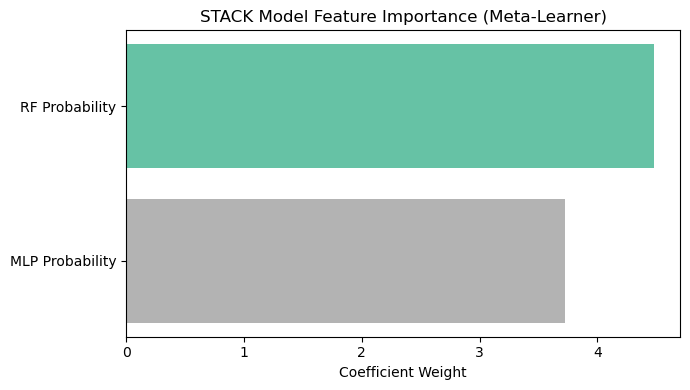

In [30]:
# =========================================
# STACK Feature Importance (Meta-Learner)
# =========================================

# Extract meta-learner from pipeline
meta_lr = meta  # already fitted LogisticRegression or pipeline

# If pipeline (StandardScaler + LogisticRegression), get last step
if hasattr(meta_lr, "named_steps"):
    meta_lr = meta_lr.named_steps["logisticregression"]

coef = meta_lr.coef_.ravel()
stack_features = ["RF Probability", "MLP Probability"]

# Sort by absolute importance (optional)
idx = np.argsort(np.abs(coef))[::-1]
coef = coef[idx]
stack_features = np.array(stack_features)[idx]

print("\nTop STACK Feature Contributions (Meta-Learner Coefficients):")
for name, weight in zip(stack_features, coef):
    print(f"{name}: {weight:.4f}")

# Plot
plt.figure(figsize=(7, 4))
colors = plt.cm.Set2(np.linspace(0, 1, len(stack_features)))
plt.barh(stack_features, coef, color=colors)
plt.xlabel("Coefficient Weight")
plt.title("STACK Model Feature Importance (Meta-Learner)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [31]:
# ============================
# Summary table: RFC vs Tuned MLP vs STACK
# ============================

# --- Helpers (safe to re-declare) ---
def best_f1_threshold_from_proba(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])

def evaluate_at_threshold(y_true, proba, thr):
    yhat = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, yhat, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_true, yhat, labels=[0,1])
    roc = roc_auc_score(y_true, proba)
    pr  = average_precision_score(y_true, proba)  # PR-AUC (Average Precision)
    return acc, prec, rec, f1, roc, pr, cm

# --- Probabilities expected to exist from your pipeline ---
# y_proba   : RFC probabilities (from final_rf)
# p_tuned   : Tuned MLP probabilities (from final_tuned_model)
# p_stack   : STACK probabilities (from meta-learner)
# y_test    : ground truth

# 1) Best thresholds (exact, no rounding for computation)
rf_thr,  _ = best_f1_threshold_from_proba(y_test, y_proba)
mlp_thr, _ = best_f1_threshold_from_proba(y_test, p_tuned)
stk_thr, _ = best_f1_threshold_from_proba(y_test, p_stack)

# 2) Evaluate each model at its own best threshold
rf_acc, rf_prec, rf_rec, rf_f1, rf_roc, rf_pr, rf_cm   = evaluate_at_threshold(y_test, y_proba, rf_thr)
mlp_acc, mlp_prec, mlp_rec, mlp_f1, mlp_roc, mlp_pr, mlp_cm = evaluate_at_threshold(y_test, p_tuned,  mlp_thr)
stk_acc, stk_prec, stk_rec, stk_f1, stk_roc, stk_pr, stk_cm = evaluate_at_threshold(y_test, p_stack,  stk_thr)

# 3) Unpack confusion matrices
rf_tn, rf_fp, rf_fn, rf_tp     = rf_cm.ravel()
mlp_tn, mlp_fp, mlp_fn, mlp_tp = mlp_cm.ravel()
stk_tn, stk_fp, stk_fn, stk_tp = stk_cm.ravel()

# 4) Build tidy DataFrame
summary = pd.DataFrame({
    "Best Threshold": [round(rf_thr, 2), round(mlp_thr, 2), round(stk_thr, 2)],
    "Accuracy":       [rf_acc, mlp_acc, stk_acc],
    "Precision":      [rf_prec, mlp_prec, stk_prec],
    "Recall":         [rf_rec, mlp_rec, stk_rec],
    "F1":             [rf_f1,  mlp_f1,  stk_f1],
    "ROC-AUC":        [rf_roc, mlp_roc, stk_roc],
    "PR-AUC":         [rf_pr,  mlp_pr,  stk_pr],
    "TN":             [rf_tn,  mlp_tn,  stk_tn],
    "FP":             [rf_fp,  mlp_fp,  stk_fp],
    "FN":             [rf_fn,  mlp_fn,  stk_fn],
    "TP":             [rf_tp,  mlp_tp,  stk_tp],
}, index=["Random Forest Classifier", "Tuned MLP", "STACK"])

# 5) Pretty print (rounded)
with pd.option_context("display.precision", 3):
    print("\n=== Best-Threshold Summary (RF vs Tuned MLP vs STACK) ===")
    print(summary)

# 7) Concise one-liners (good for logs)
print(
    f"\nRFC   @ {rf_thr:.2f} → Acc={rf_acc:.3f}, P={rf_prec:.3f}, R={rf_rec:.3f}, "
    f"F1={rf_f1:.3f}, ROC-AUC={rf_roc:.3f}, PR-AUC={rf_pr:.3f}, CM={rf_cm.tolist()}"
)
print(
    f"MLP*  @ {mlp_thr:.2f} → Acc={mlp_acc:.3f}, P={mlp_prec:.3f}, R={mlp_rec:.3f}, "
    f"F1={mlp_f1:.3f}, ROC-AUC={mlp_roc:.3f}, PR-AUC={mlp_pr:.3f}, CM={mlp_cm.tolist()}"
)
print(
    f"STACK @ {stk_thr:.2f} → Acc={stk_acc:.3f}, P={stk_prec:.3f}, R={stk_rec:.3f}, "
    f"F1={stk_f1:.3f}, ROC-AUC={stk_roc:.3f}, PR-AUC={stk_pr:.3f}, CM={stk_cm.tolist()}"
)



=== Best-Threshold Summary (RF vs Tuned MLP vs STACK) ===
                          Best Threshold  Accuracy  Precision  Recall     F1  \
Random Forest Classifier            0.57     0.911      0.259    0.44  0.326   
Tuned MLP                           0.56     0.885      0.207    0.48  0.289   
STACK                               0.67     0.863      0.215    0.68  0.327   

                          ROC-AUC  PR-AUC   TN   FP  FN  TP  
Random Forest Classifier    0.819   0.216  909   63  28  22  
Tuned MLP                   0.817   0.218  880   92  26  24  
STACK                       0.831   0.243  848  124  16  34  

RFC   @ 0.57 → Acc=0.911, P=0.259, R=0.440, F1=0.326, ROC-AUC=0.819, PR-AUC=0.216, CM=[[909, 63], [28, 22]]
MLP*  @ 0.56 → Acc=0.885, P=0.207, R=0.480, F1=0.289, ROC-AUC=0.817, PR-AUC=0.218, CM=[[880, 92], [26, 24]]
STACK @ 0.67 → Acc=0.863, P=0.215, R=0.680, F1=0.327, ROC-AUC=0.831, PR-AUC=0.243, CM=[[848, 124], [16, 34]]


### <font color='blue'>stack old v2</font>

In [32]:
# # ----------------------------
# # 0) Inner split from TRAIN (keeps TEST untouched)
# # ----------------------------
# X_tr, X_val, y_tr, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
# )

# # ----------------------------
# # 1) Train base learners on X_tr
# #    - RF: clone best RF (final_rf) and fit on X_tr
# #    - MLP: build tuned-architecture and fit on X_tr (uses your tuned best_cfg)
# # ----------------------------
# rf_stack = clone(final_rf)  # same params as your best RF
# rf_stack.fit(X_tr, y_tr)

# # Fallback tuned config if best_cfg isn't in scope
# if 'best_cfg' not in globals():
#     best_cfg = {'units': (256,128,64), 'drop': (0.4,0.3,0.2), 'lr': 0.003, 'batch_size': 256}

# # Build a fresh tuned MLP and train on X_tr (with a tiny val split inside fit)
# mlp_stack = build_mlp(units=best_cfg['units'], drop=best_cfg['drop'], lr=best_cfg['lr'])
# hist_stack = mlp_stack.fit(
#     X_tr, y_tr,
#     validation_split=0.1,
#     epochs=200,
#     batch_size=best_cfg['batch_size'],
#     verbose=0,
#     class_weight=class_weight,
#     callbacks=[early_stop, reduce_lr]
# )

# # ----------------------------
# # 2) Meta features on train/val
# # ----------------------------
# Z_tr  = np.column_stack([
#     rf_stack.predict_proba(X_tr)[:, 1],
#     mlp_stack.predict(X_tr, verbose=0).ravel()
# ])
# Z_val = np.column_stack([
#     rf_stack.predict_proba(X_val)[:, 1],
#     mlp_stack.predict(X_val, verbose=0).ravel()
# ])

# # ----------------------------
# # 3) Meta-learner
# # ----------------------------
# meta = GradientBoostingClassifier(random_state=42)
# meta.fit(Z_tr, y_tr)

# # ----------------------------
# # 4) Choose threshold on validation by F1(positive) — use EXACT value
# # ----------------------------
# val_meta_proba = meta.predict_proba(Z_val)[:, 1]
# prec_v, rec_v, thr_v = precision_recall_curve(y_val, val_meta_proba)
# f1_v = (2 * prec_v[:-1] * rec_v[:-1]) / (prec_v[:-1] + rec_v[:-1] + 1e-12)
# i_v = int(np.nanargmax(f1_v))
# best_thr_meta = float(thr_v[i_v])

# # ----------------------------
# # 5) Refit base learners on FULL TRAIN, evaluate on TEST
# #    (common practice: meta stays as trained on inner split)
# # ----------------------------
# rf_full = clone(final_rf).fit(X_train, y_train)

# # Rebuild tuned MLP and fit on full train for test-time features
# mlp_full = build_mlp(units=best_cfg['units'], drop=best_cfg['drop'], lr=best_cfg['lr'])
# hist_full = mlp_full.fit(
#     X_train, y_train,
#     validation_split=0.1,
#     epochs=200,
#     batch_size=best_cfg['batch_size'],
#     verbose=0,
#     class_weight=class_weight,
#     callbacks=[early_stop, reduce_lr]
# )

# Z_test = np.column_stack([
#     rf_full.predict_proba(X_test)[:, 1],
#     mlp_full.predict(X_test, verbose=0).ravel()
# ])

# test_meta_proba = meta.predict_proba(Z_test)[:, 1]

In [33]:
# # ----------------------------
# # 6) ROC & PR curves for the STACK
# # ----------------------------
# fpr_s, tpr_s, _  = roc_curve(y_test, test_meta_proba)
# prec_s, rec_s, _ = precision_recall_curve(y_test, test_meta_proba)
# pos_rate = (y_test == 1).mean()
# roc  = roc_auc_score(y_test, test_meta_proba)
# pr   = average_precision_score(y_test, test_meta_proba)

# # --- ROC subplot ---
# plt.figure(figsize=(12,5))

# plt.subplot(1,2,1)
# plt.plot(fpr_s, tpr_s, label=f"AUC = {roc:.3f}")
# plt.plot([0,1], [0,1], linestyle="--", color="gray")
# plt.title("ROC Curve — STACK (RF + Tuned MLP)")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate (Recall)")
# plt.legend(loc="lower right")
# plt.grid(alpha=0.3)

# # --- PR subplot ---
# plt.subplot(1,2,2)
# plt.plot(rec_s, prec_s, label=f"AP = {pr:.3f}")
# plt.hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--",
#            label=f"Baseline = {pos_rate:.3f}")
# plt.title("Precision–Recall Curve — STACK (RF + Tuned MLP)")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.legend(loc="upper right")
# plt.grid(alpha=0.3)

# plt.tight_layout()
# plt.show()

In [34]:
# # ----------------------------
# # 7) Metrics + concise report
# # ----------------------------
# y_pred_meta = (test_meta_proba >= best_thr_meta).astype(int)

# acc  = accuracy_score(y_test, y_pred_meta)
# prec, rec, f1, _ = precision_recall_fscore_support(
#     y_test, y_pred_meta, average="binary", zero_division=0
# )

# cm   = confusion_matrix(y_test, y_pred_meta, labels=[0,1])

# print("\n=== STACK (RF + Tuned MLP) — Test Results ===")
# print(f"Best Threshold = {best_thr_meta} (F1 = {f1:.3f})")
# print(f"Accuracy:  {acc:.3f}")

# print("\nConfusion Matrix:")
# print(cm)

# print("\nClassification Report — STACK (RF + Tuned MLP):")
# print(classification_report(
#     y_test, y_pred_meta,
#     target_names=["No Stroke", "Stroke"],
#     digits=3
# ))

In [35]:
# # ----------------------------
# # 8) Optional: Threshold sweep (includes exact best threshold)
# # ----------------------------
# print("\n===== STACK: Testing Different Decision Thresholds =====")
# grid = np.round(np.arange(0.00, 1.01, 0.01), 2)
# thr_grid = np.unique(np.r_[grid, best_thr_meta])  # include exact best

# for t in thr_grid:
#     yhat = (test_meta_proba >= t).astype(int)
#     a = accuracy_score(y_test, yhat)
#     p, r, f1t, _ = precision_recall_fscore_support(y_test, yhat, average="binary", zero_division=0)
#     cmt = confusion_matrix(y_test, yhat, labels=[0,1])
#     print(f"\n=== Threshold = {t:.2f} ===")
#     print(f"Acc: {a:.3f} | Prec: {p:.3f} | Rec: {r:.3f} | F1: {f1t:.3f}")
#     print("Confusion Matrix:\n", cmt)

### <font color='blue'>stack old</font>

In [36]:
# # ============================
# # Ensemble "Top Features" via Permutation Importance
# # (on the original features, for the full STACK pipeline)
# # ============================
# # Preconditions:
# # - rf_stack and dl_model are trained on full X_train (you re-fit RF above; dl_model is your trained MLP)
# # - meta is already fitted on Z_tr (from inner split). That's fine: we only need meta's learned combiner.
# # - X_test is your scaled, one-hot test matrix (np array), y_test is 0/1
# # - X.columns gives feature names in the same order as X_test columns


# def _stack_probs(Xb):
#     """Full ensemble probability for class 1 given features Xb."""
#     p_rf  = rf_stack.predict_proba(Xb)[:,1]
#     p_mlp = dl_model.predict(Xb, verbose=0).ravel()
#     Zb = np.column_stack([p_rf, p_mlp])
#     return meta.predict_proba(Zb)[:,1]

# def _stack_scores(Xb):
#     """Return (PR-AUC, F1@best_thr_meta) for the ensemble on Xb."""
#     p = _stack_probs(Xb)
#     pr_auc = average_precision_score(y_test, p)
#     yhat = (p >= best_thr_meta).astype(int)
#     _, _, f1p, _ = precision_recall_fscore_support(
#         y_test, yhat, average="binary", zero_division=0
#     )
#     return float(pr_auc), float(f1p)

# # Baseline ensemble scores
# base_pr, base_f1p = _stack_scores(X_test)

# # Permutation loop (on original features)
# feat_names = np.array(list(X.columns))
# rng = np.random.default_rng(42)
# drops = []

# for j in range(X_test.shape[1]):
#     Xp = X_test.copy()
#     Xp[:, j] = rng.permutation(Xp[:, j])  # permute column j
#     pr_j, f1_j = _stack_scores(Xp)
#     drops.append({
#         "Feature": feat_names[j],
#         "ΔPR-AUC": base_pr - pr_j,
#         "ΔF1@thr": base_f1p - f1_j,
#         "PR-AUC (perm)": pr_j,
#         "F1@thr (perm)": f1_j
#     })

# imp_stack = pd.DataFrame(drops).sort_values("ΔPR-AUC", ascending=False).reset_index(drop=True)

# # Show Top 10 features affecting the full ensemble
# topk = min(10, len(imp_stack))
# print("\nTop 10 Ensemble Permutation Importances (by ΔPR-AUC):")
# with pd.option_context("display.max_rows", topk, "display.precision", 3):
#     print(imp_stack.loc[:topk-1, ["Feature", "ΔPR-AUC", "ΔF1@thr"]])

# # Optional bar chart
# plt.figure(figsize=(10,6))
# plt.barh(imp_stack.loc[:topk-1, "Feature"], imp_stack.loc[:topk-1, "ΔPR-AUC"])
# plt.gca().invert_yaxis()
# plt.xlabel("Permutation Importance (ΔPR-AUC)")
# plt.title("Top Features — STACK (Permutation on Original Features)")
# plt.tight_layout(); plt.show()


### <font color='blue'>Blend</font>

In [37]:
# # ---------- 1) Inner validation split (no leakage) ----------
# X_tr, X_val, y_tr, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
# )

# # Refit models on the inner-train (so both see the same data for fair tuning)
# rf_blend = final_rf.__class__(**final_rf.get_params())
# rf_blend.fit(X_tr, y_tr)

# dl_blend = keras.models.clone_model(dl_model)
# dl_blend.set_weights(dl_model.get_weights())  # start from your trained weights
# # (Optional) brief fine-tune to X_tr if you want; often skipping is fine:
# # dl_blend.compile(optimizer=keras.optimizers.Adam(0.003), loss="binary_crossentropy")
# # dl_blend.fit(X_tr, y_tr, epochs=0, verbose=0)

# # ---------- 2) Get validation probabilities ----------
# rf_val = rf_blend.predict_proba(X_val)[:, 1]
# mlp_val = dl_blend.predict(X_val, verbose=0).ravel()

# # ---------- 3) Tune blending weight on validation by F1(positive) ----------
# def best_f1_and_thr(y_true, probs):
#     prec, rec, thr = precision_recall_curve(y_true, probs)
#     f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
#     i = int(np.nanargmax(f1))
#     return float(f1[i]), float(thr[i])

# weights = np.linspace(0.0, 1.0, 41)  # RF weight w; MLP weight = 1-w
# best_w, best_f1_val, best_thr_val = None, -1.0, 0.5

# for w in weights:
#     ens_val = w * rf_val + (1 - w) * mlp_val
#     f1_val, thr_val = best_f1_and_thr(y_val, ens_val)
#     if f1_val > best_f1_val:
#         best_f1_val, best_thr_val, best_w = f1_val, thr_val, w

# print(f"[BLEND] Best weight (RF) = {best_w:.2f} | (MLP) = {1-best_w:.2f} | Val F1 = {best_f1_val:.3f} @ thr={best_thr_val:.2f}")

# # ---------- 4) Refit models on full training data and evaluate on TEST ----------
# rf_blend.fit(X_train, y_train)  # full train
# # dl_blend already has the same topology/weights as dl_model; just reuse dl_model on full train:
# mlp_test = dl_model.predict(X_test, verbose=0).ravel()
# rf_test  = rf_blend.predict_proba(X_test)[:, 1]

# ens_test = best_w * rf_test + (1 - best_w) * mlp_test

# # pick best threshold by F1 on *validation*-selected threshold (use best_thr_val),
# # or recompute on test for diagnostics (avoid in final reporting). We'll use best_thr_val:
# y_pred_ens = (ens_test >= best_thr_val).astype(int)

# # Metrics
# acc  = accuracy_score(y_test, y_pred_ens)
# prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_ens, average="binary", zero_division=0)
# roc  = roc_auc_score(y_test, ens_test)
# pr   = average_precision_score(y_test, ens_test)
# cm   = confusion_matrix(y_test, y_pred_ens, labels=[0,1])

# summary_blend = pd.Series({
#     "RF weight": best_w, "MLP weight": 1-best_w, "Threshold": best_thr_val,
#     "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
#     "ROC-AUC": roc, "PR-AUC": pr,
#     "TN": cm[0,0], "FP": cm[0,1], "FN": cm[1,0], "TP": cm[1,1]
# })
# print("\n[BLEND] Test Summary\n", summary_blend.round(3))
# print("\n[BLEND] Confusion Matrix (Test):\n", cm)